# U16 financial features analysis

## 拿取資料

In [1]:
from finlab.data import Data
data = Data()

twii = data.get('發行量加權股價指數')
twii = twii['台股指數']
twii = twii[(twii.index.minute % 15 == 0)  & (twii.index.second == 0)]

import matplotlib.pyplot as plt
plt.style.use("ggplot")

twii.plot()

## 製作features

In [2]:
import talib
import numpy as np
import pandas as pd

sma = talib.SMA(twii, timeperiod=120)
wma = talib.WMA(twii, timeperiod=120)
mom = talib.MOM(twii, timeperiod=120)
k, d = talib.STOCH  (twii, twii, twii, fastk_period=120, slowk_period=60, slowd_period=60)
k2, d2 = talib.STOCH(twii, twii, twii, fastk_period=240, slowk_period=120, slowd_period=120)
k3, d3 = talib.STOCH(twii, twii, twii, fastk_period=360, slowk_period=180, slowd_period=180)
k4, d4 = talib.STOCH(twii, twii, twii, fastk_period=480, slowk_period=240, slowd_period=240)
k5, d5 = talib.STOCH(twii, twii, twii, fastk_period=640, slowk_period=320, slowd_period=320)
k6, d6 = talib.STOCH(twii, twii, twii, fastk_period=720, slowk_period=360, slowd_period=360)
k7, d7 = talib.STOCH(twii, twii, twii, fastk_period=840, slowk_period=420, slowd_period=420)
k8, d8 = talib.STOCH(twii, twii, twii, fastk_period=960, slowk_period=480, slowd_period=480)

rsi = talib.RSI (twii, timeperiod=120)
rsi2 = talib.RSI(twii, timeperiod=240)
rsi3 = talib.RSI(twii, timeperiod=480)
rsi4 = talib.RSI(twii, timeperiod=640)
rsi5 = talib.RSI(twii, timeperiod=720)
rsi6 = talib.RSI(twii, timeperiod=840)

macd1, macd2, macd3 = talib.MACD(twii, fastperiod=120, slowperiod=60, signalperiod=60)
willr = talib.WILLR(twii, twii, twii, timeperiod=120)
cci = talib.CCI(twii, twii, twii, timeperiod=120)

dataset = pd.DataFrame({
    'RSIb': rsi / 50,
    'RSIb2': rsi2 / 50,
    'RSIb3': rsi3 / 50,
    'RSIb4': rsi4 / 50,
    'RSIb5': rsi5 / 50,
    'RSIb6': rsi6 / 50,
    'MOMb': mom - 0,
    'KDb': k - d,
    'KDb2': k2 - d2,
    'KDb3': k3 - d3,
    'KDb4': k4 - d4,
    'KDb5': k5 - d5,
    'KDb6': k6 - d6,
    'KDb7': k7 - d7,
    'KDb8': k8 - d8,
    
    'a5':   (twii.rolling(5).mean()   / twii),
    'a10':  (twii.rolling(10).mean()  / twii),
    'a20':  (twii.rolling(20).mean()  / twii),
    'a40':  (twii.rolling(40).mean()  / twii),
    'a80':  (twii.rolling(80).mean()  / twii),
    'a160': (twii.rolling(160).mean() / twii),
    'a320': (twii.rolling(320).mean() / twii),
    'a640': (twii.rolling(640).mean() / twii),
    'a720': (twii.rolling(720).mean() / twii),
    'a840': (twii.rolling(840).mean() / twii),
    'a960': (twii.rolling(960).mean() / twii),
    'a1024':(twii.rolling(1024).mean() / twii),
    'b1': twii/twii.shift(50),
    'b2': twii/twii.shift(100),
    'b3': twii/twii.shift(150),
    'b4': twii/twii.shift(200),
    'b5': twii/twii.shift(250),
    'b6': twii/twii.shift(300),
    'b7': twii/twii.shift(350),
    'LINEARREG_SLOPE0': talib.LINEARREG_SLOPE(twii, 60),
    'LINEARREG_SLOPE1': talib.LINEARREG_SLOPE(twii, 120),

    'ADXR0': talib.ADXR(twii, twii, twii, 60),
    'ADXR1': talib.ADXR(twii, twii, twii, 120),
    'ADXR2': talib.ADXR(twii, twii, twii, 240),
    'ADXR3': talib.ADXR(twii, twii, twii, 360),
    'ADXR4': talib.ADXR(twii, twii, twii, 480),
    'ADXR5': talib.ADXR(twii, twii, twii, 640),

    'return': twii.shift(-10) > twii,
})

feature_names = list(dataset.columns[:-1])

## 訓練

In [3]:
import lightgbm as lgb

dataset_train = dataset[:'2015']
dataset_test = dataset['2016':]

train = dataset_train[feature_names], dataset_train['return']
test = dataset_test[feature_names], dataset_test['return']

gbm = lgb.LGBMClassifier(n_estimators=1000, random_state=5, learning_rate=0.05)
gbm.fit(*train)
gbm.score(*test)

/Users/cheng-yuhan/miniconda3/envs/finlab/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


0.4935143710339679

## 測試哪些feature重要

/Users/cheng-yuhan/miniconda3/envs/finlab/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


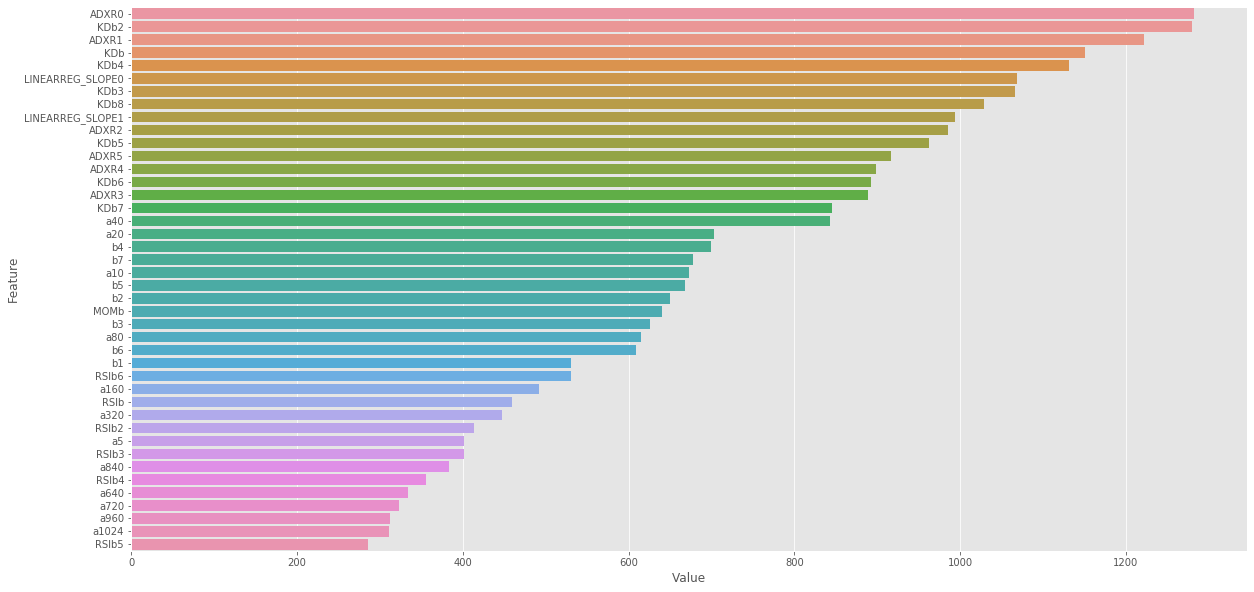

In [4]:
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importances_,feature_names)), columns=['Value','Feature'])
feature_imp

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))

## 回測一下

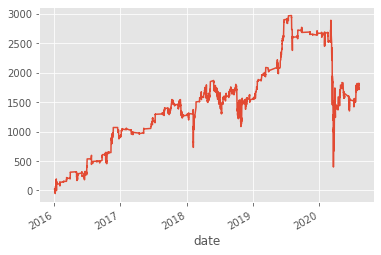

In [5]:
ey = gbm.predict_proba(dataset[feature_names])
ey = pd.Series(ey.swapaxes(0,1)[1], index=dataset.index)

eq = twii[dataset.index]
gain = ((eq.shift(-1) - eq))

signal = (ey > ey.quantile(0.7)).rolling(10).sum() > 0
eq = (gain[signal]['2016':]).cumsum()
eq.plot()

## 手續費+滑價

In [6]:
signal['2016'].astype(int).diff().abs().sum()

70.0

# U17 Model Interpretation

## Recall and Precision

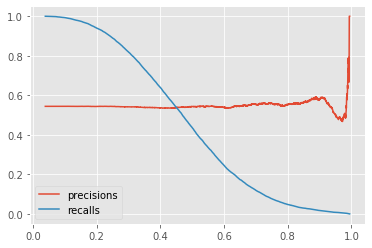

In [7]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(dataset['return']['2016':], ey['2016':])

pd.DataFrame({
    'precisions':precisions[:-1],
    'recalls':recalls[:-1],
}, index=thresholds).plot()


## ROC Curve

(10425,)
(10425,)
(10425,)


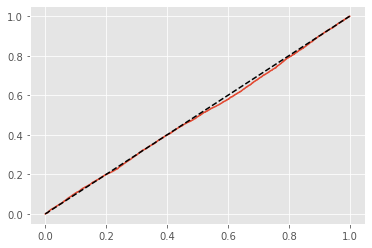

In [8]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(dataset['return']['2016':], ey['2016':])

print(fpr.shape)
print(tpr.shape)
print(thresholds.shape)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')

### 使用 eli5 察看機器學習如何做決定

In [9]:
import eli5

eli5.explain_prediction_lightgbm(gbm, dataset[feature_names].iloc[10])

Explanation(estimator="LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,\n               importance_type='split', learning_rate=0.05, max_depth=-1,\n               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,\n               n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,\n               random_state=5, reg_alpha=0.0, reg_lambda=0.0, silent=True,\n               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=True, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='a80', weight=1.0100766039056945, std=None, value=nan), FeatureWeight(feature='a40', weight=0.7455934295741518, std=None, value=nan), FeatureWeight(feature='b2', weight=0.32657849412660844, std=None, value=nan), FeatureWeight(feature='a160', weight=0.3066316745674835, std=None, value=nan), FeatureWeight(feature='b1', weight=0.22364982638525005, std=None, value=nan), FeatureWeight(feature='a10', weight=0.16020515158461712, std=None, value=1.0025177980671949), FeatureWeight(feature='ADXR5', weight=0.1399170713620707, std=None, value=nan), FeatureWeight(feature='LINEARREG_SLOPE0', weight=0.13166229846647304, std=None, value=nan), FeatureWeight(feature='ADXR1', weight=0.12012593518879174, std=None, value=nan), FeatureWeight(feature='b5', weight=0.11707945966720397, std=None, value=nan), FeatureWeight(feature='ADXR0', weight=0.11169224201524534, std=None, value=nan), FeatureWeight(feature='KDb3', weight=0.10993777051489365, std=None, value=nan), FeatureWeight(feature='LINEARREG_SLOPE1', weight=0.10573443501075554, std=None, value=nan), FeatureWeight(feature='KDb6', weight=0.10157199159031345, std=None, value=nan), FeatureWeight(feature='b4', weight=0.101232376806253, std=None, value=nan), FeatureWeight(feature='a5', weight=0.098031790287311, std=None, value=0.9998637602179834), FeatureWeight(feature='<BIAS>', weight=0.0933239209288183, std=None, value=1.0), FeatureWeight(feature='ADXR3', weight=0.05805801739101117, std=None, value=nan), FeatureWeight(feature='b3', weight=0.05016659227724955, std=None, value=nan), FeatureWeight(feature='a320', weight=0.04731732677701714, std=None, value=nan), FeatureWeight(feature='a720', weight=0.0460244391564646, std=None, value=nan), FeatureWeight(feature='RSIb2', weight=0.04502284772793087, std=None, value=nan), FeatureWeight(feature='KDb5', weight=0.03339195351329718, std=None, value=nan), FeatureWeight(feature='RSIb3', weight=0.03034798034827981, std=None, value=nan), FeatureWeight(feature='KDb8', weight=0.029608105958233565, std=None, value=nan), FeatureWeight(feature='RSIb6', weight=0.02620179668773504, std=None, value=nan), FeatureWeight(feature='a840', weight=0.014753586316930606, std=None, value=nan), FeatureWeight(feature='RSIb', weight=0.013993970021733096, std=N

### 使用Skater來察看機器學習如何做實驗

In [50]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

# 新版的skater 不支援 dataset 中有 nan，必須先將有 nan 的 rows 移除喔！
dataset_train_dropna = dataset_train.dropna(how='any')


interpreter = Interpretation(training_data=dataset_train_dropna[feature_names].values,
                             feature_names=feature_names, training_labels=dataset_train_dropna['return'].values)
im_model = InMemoryModel(lambda x: gbm.predict_proba(x).swapaxes(0,1)[0], examples=train[0],
                         target_names=['down', 'rise'])



2020-12-29 12:22:13,283 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[42/42] features ████████████████████ Time elapsed: 11 seconds

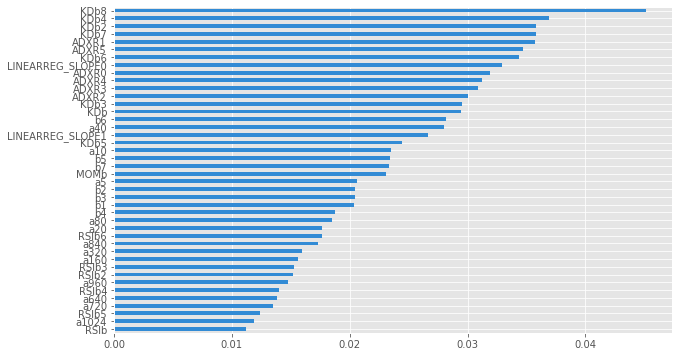

In [51]:
plt.rcParams['figure.figsize'] = (10, 6)
plots = interpreter.feature_importance.plot_feature_importance(im_model)

#### 1. 挑幾項出來看

2020-12-29 12:20:51,666 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[100/100] grid cells ████████████████████ Time elapsed: 18 seconds

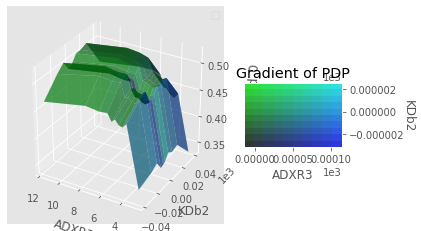

In [49]:
r = interpreter.partial_dependence.plot_partial_dependence([('ADXR3', 'KDb2')], im_model, grid_resolution=10, 
                                                           grid_range=(0,1), n_samples=1000, n_jobs=1,
                                                           with_variance=False, figsize = (6, 4), )

#### 分析為何判定會漲？

In [52]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

exp = LimeTabularExplainer(dataset_test[feature_names].values, feature_names=feature_names)

doc_num = 0
exp.explain_instance(dataset_test[feature_names].iloc[doc_num], gbm.predict_proba).show_in_notebook()


In [53]:
doc_num = 0
print('Actual Label:', dataset_test['return'].iloc[doc_num])
print('Predicted Label:', gbm.predict_proba(dataset_test[feature_names])[0])
exp.explain_instance(dataset_test[feature_names].iloc[doc_num], gbm.predict_proba).show_in_notebook()


Actual Label: False
Predicted Label: [0.91319238 0.08680762]


### SHAP 分析package

In [23]:
import shap
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(dataset_test[feature_names][::10])
print('Expected Value:', explainer.expected_value)
pd.DataFrame(shap_values[1]).head()

Expected Value: [-0.09332392092881839, 0.09332392092881839]


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


0         1         2         3         4         5         6   \
0 -0.026141  0.010828 -0.003429 -0.001598 -0.032882 -0.000331  0.077681   
1  0.068779  0.042936  0.046220 -0.005756 -0.055256  0.007345  0.046367   
2  0.061513  0.028681  0.040399  0.003800 -0.008120  0.063450  0.052495   
3  0.035796  0.005457  0.048834 -0.022514 -0.009429  0.033960  0.019418   
4  0.031783  0.015701  0.039557  0.036222  0.003990 -0.016656  0.048073   

         7         8         9   ...        32        33        34        35  \
0 -0.263379 -0.029822 -0.055489  ...  0.000246 -0.069104 -0.014920 -0.162342   
1 -0.220837 -0.051301 -0.012748  ... -0.028277 -0.101205  0.037256 -0.069135   
2 -0.094484  0.039345 -0.002287  ... -0.015556 -0.040848 -0.048051 -0.144728   
3 -0.081016  0.063129 -0.029342  ...  0.008108 -0.091657 -0.096676 -0.126493   
4 -0.041104 -0.338615  0.005634  ... -0.063109 -0.049068 -0.013155 -0.121665   

         36        37        38        39        40        41  
0  0.002438 -0.240185 -0.016484 -0.486602 -0.094992 -0.122373  
1 -0.034159 -0.239036  0.115579 -0.162961 -0.089711 -0.136394  
2 -0.099126 -0.221737  0.200248  0.324462  0.015294 -0.185409  
3 -0.054461 -0.170564  0.174072  0.288195  0.048004 -0.167173  
4 -0.064601 -0.161114  0.130254  0.282355 -0.114907 -0.204881  

[5 rows x 42 columns]

In [31]:
shap.initjs()

doc_id = 100

shap.force_plot(explainer.expected_value[1],
                shap_values[1], feature_names=feature_names)

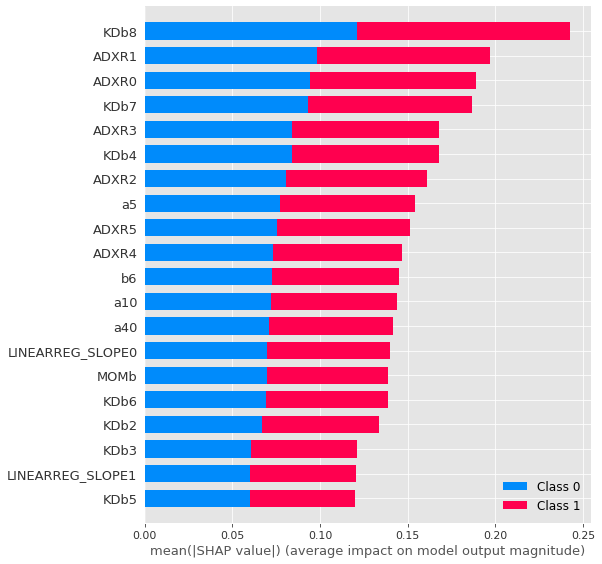

In [32]:
shap.summary_plot(shap_values, dataset_test[feature_names])


## 傳統策略研發

In [33]:
def backtest(k1, k2, plot=False):
    
    k2, d2 = talib.STOCH(twii, twii, twii, fastk_period=k1, slowk_period=k2, slowd_period=k2/2)
    buy = k2 > d2
    sell = k2 < d2

    hold = pd.Series(np.nan, index=twii.index)
    hold[buy] = 1
    hold[sell] = -1
    hold.ffill(inplace=True)

    if (hold == 1).sum() == 0:
        return 1
    
    returns = twii.shift(-1) - twii
    
    if plot:
        
        returns[hold == 1][:'2015'].cumsum().plot()
    
    return returns[hold == 1][:'2015'].cumsum().iloc[-1]
   

maxr = 0
for k1 in range(40, 100, 1):
    for k2 in range(40, 100, 1):
        if k1 <= k2:
            continue
        r = backtest(k1, k2)
        if r > maxr:
            print(r, k1, k2)
            maxr = r

5100.990000000028 41 40
5169.2200000000175 42 41
5490.780000000027 45 44
5579.139999999983 48 46
5764.709999999992 48 47
5939.849999999988 49 46
6200.129999999991 49 47
7080.680000000016 49 48
7252.970000000013 50 48
7460.550000000011 50 49
7469.360000000006 51 49
7671.48 51 50
8251.830000000014 52 51
9400.670000000027 53 52
9590.00000000005 54 53
9652.460000000012 55 54
9834.380000000046 56 52
10205.06000000003 56 54
10235.449999999986 70 58
10846.449999999992 72 56
10876.719999999996 74 56
11356.480000000021 75 57
11467.660000000036 76 57
11547.580000000013 83 57
11702.410000000003 84 57


11563.200000000017

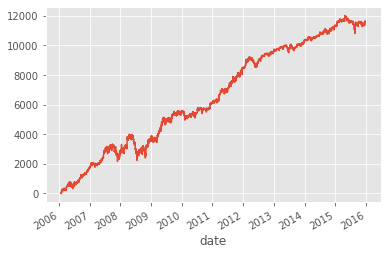

In [34]:
backtest(88, 56, True)